# Importing all necessary project-data
* libraries and csv-files
* either local usage or online-collaboration 

In [15]:
# local usage

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

filepath_1 = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_3_Data_Cleaning\brands.csv"
filepath_2 = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_3_Data_Cleaning\orderlines.csv"
filepath_3 = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_3_Data_Cleaning\orders.csv"
filepath_4 = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_3_Data_Cleaning\products.csv"

brands = pd.read_csv(filepath_1, sep = ",")
orderlines = pd.read_csv(filepath_2, sep = ",")
orders = pd.read_csv(filepath_3, sep = ",")
products = pd.read_csv(filepath_4, sep = ",")


In [ ]:
# online collaboration

import pandas as pd
import numpy as np

# brands.csv
url = "https://drive.google.com/file/d/1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD/view?usp=share_link"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path, sep =",")

# orders.csv
url = "https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders = pd.read_csv(path, sep =",")

# orderlines.csv
url = "https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines = pd.read_csv(path, sep =",")

# products.csv
url = "https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=share_link"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products = pd.read_csv(path, sep =",")

# Adjusting output-format

In [16]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

# Setting up dataframe-copies 

In [17]:
b = brands.copy()
o = orders.copy()
ol = orderlines.copy()
p = products.copy()

# DATACLEANING BRANDS-DATAFRAME
- corrected long values for 2 missing brands and specified Apple second hand

In [18]:
b.info() # 187 values in both columns
b.short.nunique() # 187 unique values 
b.long.nunique() # 181 unique values
b.groupby("long").agg({"short": "count"}).sort_values(by="short", ascending=False).head(6) # adressing the differential from the numbers above, showing brandnames with 2 shorts
b[b.long.isin(["Jaybird", "Apple", "Unknown", "Mophie", "Startech", "Bose"])] # getting a grip on those
b[b.short.str.contains("\d")] # showing two tags with digits, important at later stage
#after crosschecking with products-DF:
# "KEN" is not Jaybird but Kensington 
# "MUJ" is not Mophie but Mujjo
# "CAD" not to be found in products, but in orderlines --> will be dropped from orderlines when checking for matching SKUs
# "AP2" represents refurbished/second-hand Apple-products
# "OTR" represents a variety of brands (Startech among them)
b.long[b.short == "KEN"] = "Kensington"
b.long[b.short == "MUJ"] = "Mujjo"
b.long[b.short == "AP2"] = "Apple 2nd-hand"
b_cl = b # setting b_cl as cleaned DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


# DATACLEANING ORDERS-DATAFRAME
- conversion to datetime
- dropping all non-completed orders

In [19]:
o.info()
o.created_date = pd.to_datetime(o.created_date) #converting created_date to datetime
#o.state.value_counts() #getting an impression of "state"-distribution
#o.groupby("state").agg({"created_date": "mean"}) ## in general between sep 6 and sep 12 2017, "Pending" in JULY
#o.groupby("state").agg({"created_date": "median"}) ## in general between oct 6 and oct 27 2017, "Pending" in JUNE
# since pending-orders are much older than the other orders they are discarded
# place orders does not give information what happened so far - since the date-values are very similar to completed orders "place order" is discarded from further analysis
o = o[o.state == "Completed"]
#o.dropna() #no changes
#o.info()
#o.drop_duplicates() #no changes
#o.info()
o_cl = o #storing the cleaned DF in new "variable"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


# Options for "state"-treatment

In [ ]:
# o = o[o.state == "Place Order"] # for comparisons
# o = o[(o.state == "Completed") | (o.state == "Place Order")] # if we decide to include both

# DATACLEANING ORDERLINES-DATAFRAME
- dropping ol.product_id (value = 0 in each cell)
- dropping ol.id (unique value for each row providing no further information compared to DF-index)
- conversion ol.date to datetime
- renaming ol.id_order to ol.order_id (thus creating a corresponding column for merging with o)
- converting ol.unit_prices to float (after fixing values that contained double-decimals)

In [22]:
ol.info() # getting an overview
#ol.id.nunique() #293983 --> unique for each row
#ol.id_order.nunique() #204855 --> smaller number suggesting some orders contains several items
#ol.sku.nunique() #7951 unique skus in orders
#ol.head(1)
#ol.product_id.value_counts() # whole column with value = 0, thus providing no information at all
ol.drop("product_id", axis = 1, inplace = True) # deleting that column
ol.drop("id", axis = 1, inplace = True)
ol.date = pd.to_datetime(ol.date) # converting date to datetime-datatype
#comparing the values from orderlines.id_order and orders_order_id shows similar values, thus renaming orderlines.id_order accordingly
ol.rename(columns={"id_order": "order_id"}, inplace=True)
#ol.unit_price = pd.to_numeric(ol.unit_price) # unexpected error, needs investigation
ol.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          293983 non-null  int64         
 1   product_quantity  293983 non-null  int64         
 2   sku               293983 non-null  object        
 3   unit_price        293983 non-null  object        
 4   date              293983 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          293983 non-null  int64         
 1   product_quantity  293983 non-null  int64         
 2   sku               293983 non-null  object        
 3   unit_price        293983 non-null  object    

In [8]:
# as the problems with regard to conversion of price-columns already were known from a previous work on the products-dataframe the data was checked for having too many decimals
ol["unit_price"].str.contains("\d+\.\d+\.\d*").value_counts() # 36k occurences
ol[(ol["unit_price"].str.contains("\d+\.\d+\.\d*")) & (ol["unit_price"].str.len() > 8)].tail(50) # getting a closer look at those values --> pattern looks like a an additional decimal at the 1000-position
ol.head()

,order_id,product_quantity,sku,unit_price,date
0,299539,1,OTT0133,18.99,2017-01-01 00:07:19
1,299540,1,LGE0043,399.00,2017-01-01 00:19:45
2,299541,1,PAR0071,474.05,2017-01-01 00:20:57
3,299542,1,WDT0315,68.39,2017-01-01 00:51:40
4,299543,1,JBL0104,23.74,2017-01-01 01:06:38


In [23]:
#creating a new column with cleaned prices
ol["unit_price_cl"] = (
    np.where((ol["unit_price"].str.contains("\d+\.\d+\.\d*")), (pd.to_numeric(ol["unit_price"].str.replace(".", ""))/100).round(2), #removing the decimals, but adding the EUR/ct-separator again
    ol["unit_price"]) # keeping prices with correct format
)
ol["unit_price_cl"] = pd.to_numeric(ol["unit_price_cl"]).round(2) # converting that column to numeric(float)
ol.sort_values(by="unit_price_cl", ascending= False) # checking values, one single value looks way too big
ol.iloc[36979, 5] = (ol.iloc[36979, 5]/1000).round(2) #adjustment after crosschecking with products.prices
ol_cl = ol 
ol_cl.info()# setting the cleaned df to ol_cl

C:\Users\danie\AppData\Local\Temp\ipykernel_24536\3228655814.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  np.where((ol["unit_price"].str.contains("\d+\.\d+\.\d*")), (pd.to_numeric(ol["unit_price"].str.replace(".", ""))/100).round(2), #removing the decimals, but adding the EUR/ct-separator again


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          293983 non-null  int64         
 1   product_quantity  293983 non-null  int64         
 2   sku               293983 non-null  object        
 3   unit_price        293983 non-null  object        
 4   date              293983 non-null  datetime64[ns]
 5   unit_price_cl     293983 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 13.5+ MB


# Option for including brand-tags in orderlines
- might be useful for merging purposes

In [ ]:
# if needed code for brand-tags in ol:
# crosschecking if the doubled shorts are in products or orderlines
# extracting brand-tags from SKU
#ol["brands"] = ol["sku"].str.replace("\d", "")
#ol["short"] = (
#    np.where((ol["brands"].str.len()>3), (ol["brands"].str.split("-")[0]),
#    np.where((ol["brands"] == "MO"), "8MO",
#    np.where((ol["brands"] == "AP"), "APP",
#    ol["brands"])))
#)

#removing numeric values from SKU in order to get brand-tag, stroring values in new column
#not all values are in "ABC"-format - some are longer
#(ol_df["brands"].str.len()>3).value_counts() #11193 entries longer than 3 chars
#ol_df[ol_df["brands"].str.len()>3] #showing the pattern of sku having sometimes a "-" followed by char --> splitting these strings and storing the 3 char-tags in new column

# DATACLEANING PRODUCTS-DATAFRAME
- dropping duplicate-rows
- dropping rows with na-values
- dropping rows with corrupted price-values
- conversion p.price to float
- dropping p.promo_price (more than 90% of values are corrupted)
- creating p.short (column that matches brands.short for merging purposes; extracted from p.sku)

In [24]:
#p.info() # both promo-prices and prices are non-numeric
#p.duplicated().sum() # looking for duplicates as suggested by workbook: 8.7k duplicates to be removed
#pg = products.groupby("sku").agg({"name": "count"}).sort_values("name", ascending=False) #giving an impression how many lines per sku exist
#products[products["sku"] == "PAC1035"] #looking at one example of a sku with multiple name rows --> seems fair to drop the muliple rows (sku should be a unique identifier)
p = p.drop_duplicates()
#p.isna().sum() #50 missing types, 46 missing prices, 7 missing descriptions in a 10k row DF, fair enough to drop these rows
p = p.dropna()
#p.price = pd.to_numeric(p.price) #error due to double decimals
#p.promo_price = pd.to_numeric(p.promo_price) #again double decimals

In [9]:
# adressing the wrongly formatted prices in products.prices
# assessing quality of the data found in products.price and products.promo_price:
p["price"].str.contains("\d+\.\d\d\d").value_counts()
# 9940 false, 537 true
p.price.str.contains("\d+\.\d+\.\d+").value_counts()
# 10104 false, 373 true
#p.sort_values("price", ascending=False) #double digit error looks like having 3 digits after last decimals, thus adressing this first
#p[p.price.str.contains("\d+\.\d\d\d")].sort_values("price", ascending=False) #having a closer look 

False    10104
True       373
Name: price, dtype: int64

In [25]:
#setting up a new column for corrected prices by estimated pattern: 

#p["price_cl"] = (
#    np.where(((p["price"].str.contains("\d+\.\d\d\d", regex = True)) & (p["price"].str.len() > 7)), (pd.to_numeric(p["price"].str.replace(".", ""))/100000).round(2),
#    np.where(((p["price"].str.contains("\d+\.\d\d\d", regex = True)) & (p["price"].str.len() <= 7)), (pd.to_numeric(p["price"].str.replace(".", ""))/1000).round(2),
#    p["price"]))
#)
#p[p.price.str.contains("\d+\.\d\d\d")].sort_values("price", ascending=False)
#p.price_cl = p.to_numeric(p["price_cl"]).round(2)

# !!! Correction does not work, manually checking adjusted prices in products table does not give plausible results !!!
# since only approx. 5% values of product.price are affected, dropping those lines seems reasonable due to time-constraints
p_corrupt = p.loc[p.price.str.contains("\d+\.\d\d\d")].index
p.drop(p_corrupt, inplace = True)
p.price = pd.to_numeric(p.price)

In [26]:
# analouge to product.price product.promo_price is corrupted, since more than 90% of values are affected, the whole column is discarded
p.drop("promo_price", axis = 1, inplace = True)

In [27]:
#setting up a "short" column by extracting the brand-tag from sku for merging purposes with brands.DF:
# extracting brand-tags from sku
p["brands"] = p["sku"].str.replace("\d", "") #creating a temporary column to store the non-numeric values from sku
p["short"] = (
    np.where((p["brands"].str.len()>3), (p["brands"].str.split("-")[0]),
    np.where((p["brands"] == "MO"), "8MO",
    np.where((p["brands"] == "AP"), "AP2",
    p["brands"])))
)
p.drop("brands", axis = 1, inplace = True)
p_cl = p # storing as clean DF
p_cl.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sku       9940 non-null   object 
 1   name      9940 non-null   object 
 2   desc      9940 non-null   object 
 3   price     9940 non-null   float64
 4   in_stock  9940 non-null   int64  
 5   type      9940 non-null   object 
 6   short     9940 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 879.3+ KB


C:\Users\danie\AppData\Local\Temp\ipykernel_24536\3417014798.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  p["brands"] = p["sku"].str.replace("\d", "") #creating a temporary column to store the non-numeric values from sku


# Option for dropping p.in_stock and p.type
- p.in_stock does not seem to have relevant information for further analysis
- p.type might be useful to create product categories

In [ ]:
p.drop("in_stock", axis = 1, inplace = True)
p.drop("type", axis = 1, inplace = True)

# checking whether the corrected prices in ol_cl.unit_price_cl are in line with those given in p_cl.price
- top 500 have disounts > 47%, top 100 > 69%, top 20 > 80%. !!! are those values plausible? !!!
- almost 200 sku have negative discounts
- how to explain those values? maybe better fix for unit_price? or dropping those ol_cl-prices with double decimals?
- how to handle these sku?

In [62]:
# dropping non-exisitng (no entry in p_cl) skus from ol_cl

ol_cl["matching_sku"] = (
    np.where(ol_cl.sku.isin(p_cl.sku), True, False)
)
ol_nonmatch_sku = ol_cl[ol_cl["matching_sku"] == False].index
ol_cl.drop(ol_nonmatch_sku)

# merge ol_cl and p_pl on sku to analyse the different price-values

olines_prod = ol_cl.merge(p_cl, on = "sku", how = "inner")
olines_prod["price_diff"] = olines_prod.price - olines_prod.unit_price_cl
olines_prod["discount"] = olines_prod.price_diff/olines_prod.price
test2 = olines_prod.groupby("sku").agg({"discount": "mean", "price_diff": "mean", "product_quantity": "sum"}).sort_values("discount", ascending=False).reset_index()
test2.tail()

neg_discount = test2[test2.discount < 0]

#test2.drop(test2.loc[(test2.sku=="SEV0021") | (test2.sku=="TUC0280"), :].index, inplace=True)
#sns.catplot(data=test2,
#x="discount",
#kind="box",
#aspect=3)

In [78]:
#neg_discount.info()

#olines_prod.date = olines_prod.date.dt.date

neg_disc_skus = olines_prod[(olines_prod.sku.isin(neg_discount.sku))&(olines_prod.discount<0)]
#neg_disc_skus.info()
neg_disc_skus.groupby(by =["sku","name", "date"]).agg({"price": "mean", "product_quantity": "sum", "unit_price_cl": "max", "discount": "mean"}).sort_values("discount").head(300)

price  \
sku       name                                               date                 
TUC0280   Tucano SOTTILE ultraslim 8/7 Transparent iPhone... 2017-06-16    7.90   
SHE0045   SwitchEasy iPhone Case 8 Plus 0.35 / 7 Plus White  2017-11-23    9.99   
SEV0021   SSD installation service MacBook Pro Retina        2017-07-04   49.99   
SPE0206   Presidio Speck Case iPhone 8/7 / 6s / 6 Transpa... 2017-12-13   24.95   
IFX0074   iFixit piece Earpiece Speaker iPhone 6             2017-04-22    7.99   
                                                             2017-01-11    7.99   
                                                             2017-08-11    7.99   
                                                             2017-07-20    7.99   
                                                             2017-08-10    7.99   
                                                             2017-03-03    7.99   
REP0323   Full screen repair iPhone 6s Plus                  2017-03-13  109.99   
PRY0007   Prynt iPhone Case Black Portable Printer           2017-07-31   74.99   
                                                             2017-08-17   74.99   
                                                             2017-08-19   74.99   
                                                             2017-09-21   74.99   
                                                             2017-08-03   74.99   
                                                             2017-08-14   74.99   
                                                             2017-08-07   74.99   
PRY0008   Prynt White iPhone Case Portable Printer           2017-07-27   74.99   
                                                             2017-07-11   74.99   
                                                             2017-07-05   74.99   
REP0300   Full screen repair iPhone 6 Plus                   2017-03-16   99.99   
REP0093   iPad 2 battery repair                              2018-02-04   69.99   
                                                             2017-10-28   69.99   
KIN0149-2 Mac memory Kingston 16GB (2x8GB) SO-DIMM DDR3åÊ... 2017-03-06  105.98   
                                                             2017-04-18  105.98   
                                                             2017-03-13  105.98   
                                                             2017-04-11  105.98   
                                                             2017-03-18  105.98   
                                                             2017-03-24  105.98   
                                                             2017-03-31  105.98   
                                                             2017-04-04  105.98   
                                                             2017-02-14  105.98   
REP0396   Full screen repair iPhone 7 Plus                   2017-09-01  119.99   
                                                             2017-08-14  119.99   
                                                             2017-12-10  119.99   
                                                             2017-11-29  119.99   
                                                             2018-02-03  119.99   
                                                             2017-09-04  119.99   
                                                             2017-11-21  119.99   
                                                             2017-11-20  119.99   
                                                             2017-09-14  119.99   
                                                             2017-08-02  119.99   
                                                             2017-07-24  119.99   
                                                             2017-12-26  119.99   
                                                             2017-09-20  119.99   
                                                             2017-07-25  119.99   
       

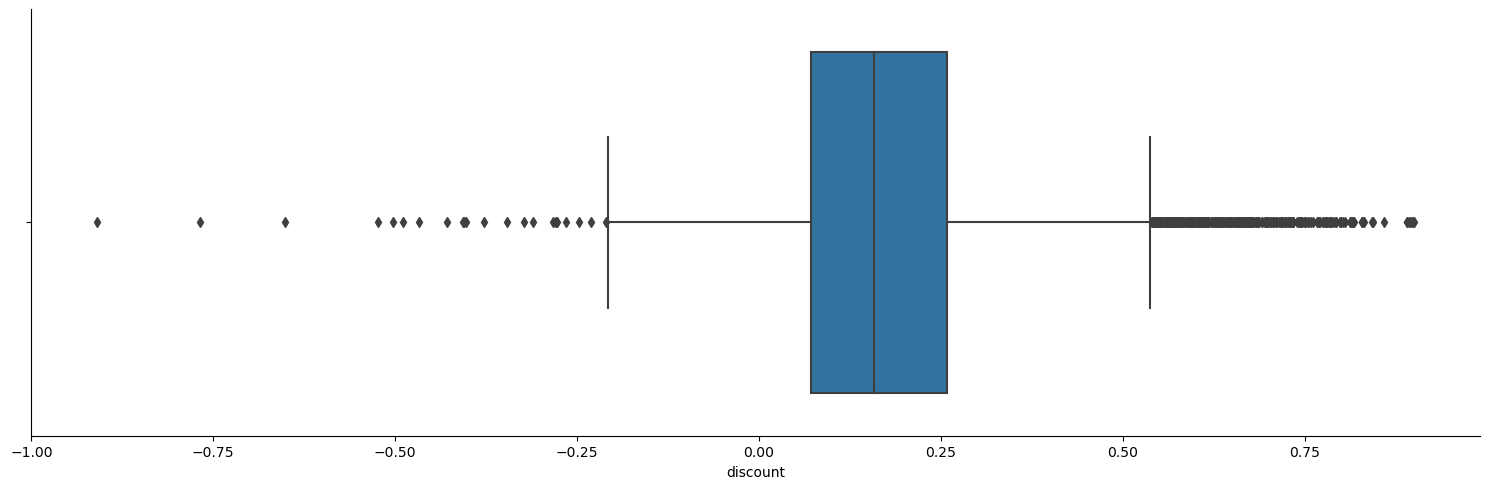

In [56]:
test2.drop(test2.loc[(test2.sku=="TUC0280"), :].index, inplace=True)
#test2.tail()
sns.catplot(data=test2,
x="discount",
kind="box",
aspect=3)